In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from IPython.display import display
from keras.utils.vis_utils import plot_model

In [2]:
if not os.path.isfile('processed_dataset.zip'):
  os.system(' '.join(['cp', 'drive/MyDrive/IT416/processed_dataset.zip', 'processed_dataset.zip']))

In [3]:
if not os.path.isdir('processed_dataset'):
  os.system(' '.join(['unzip', 'processed_dataset.zip']))

In [4]:
def get_dataset(num_people):
  x1 = []
  x2 = []
  y  = []
  for i in range(num_people):
      for j in range(10):
          path = 'processed_dataset' + '/' + 'person' + str(i+1) + '/' + 'face' + '/' + str(j+1) + '.pgm'
          image = cv2.imread(path, -1)
          image = cv2.resize(image, (12, 12))
          image = image.reshape(12, 12, 1)
          x1.append(image)
      gait_folder = 'processed_dataset' + '/' + 'person' + str(i+1) + '/' + 'gait' + '/'
      styles = os.listdir(gait_folder)
      styles.sort()
      for j, style in enumerate(styles):
          style_folder = gait_folder + style + '/'
          angles = os.listdir(style_folder)
          angles.sort()
          x = []
          for angle in angles:
              angle_folder = style_folder + angle + '/'
              images = os.listdir(angle_folder)
              images.sort()
              xx = []
              for image in images:
                  path = angle_folder + image
                  img = cv2.imread(path, -1)
                  img = cv2.resize(img, (64, 64))
                  img = np.array(img, dtype=np.float16)
                  xx.append(img)
              xx = np.array(xx, dtype=np.float16)
              x.append(xx)
          x = np.stack(x, axis=3)
          x2.append(x)
      for j in range(10):
          y.append(i)
  x1 = np.array(x1, dtype = np.float32)
  x2 = np.array(x2, dtype = np.float32)
  y = tf.keras.utils.to_categorical(y)
  x1, x2, y = shuffle(x1, x2, y)
  return x1, x2, y

In [5]:
num_people = 40
x_face, x_gait, y = get_dataset(num_people)

print('x_face:', x_face.shape)
print('x_gait:', x_gait.shape)
print('y     :', y.shape)

x_face: (400, 12, 12, 1)
x_gait: (400, 32, 64, 64, 11)
y     : (400, 40)


In [6]:
face_input = tf.keras.layers.Input(shape = (12, 12, 1), name = 'face_input')

face_encoder = tf.keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu', name = 'face_conv_1')(face_input)
face_encoder = tf.keras.layers.Dropout(0.3, name = 'face_dropout_1')(face_encoder)
face_encoder = tf.keras.layers.Flatten(name = 'face_flatten_1')(face_encoder)
face_encoder = tf.keras.layers.Dense(64, activation = 'relu', name = 'face_dense_1')(face_encoder)
face_encoder = tf.keras.layers.Dropout(0.3, name = 'face_dropout_2')(face_encoder)

gait_input = tf.keras.layers.Input(shape = (32, 64, 64, 11), name = 'gait_input')

gait_encoder = tf.keras.layers.ConvLSTM2D(16, kernel_size = 3, return_sequences = True, name = 'gait_convlstm_1')(gait_input)
gait_encoder = tf.keras.layers.Dropout(0.5, name = 'gait_dropout_1')(gait_encoder)
gait_encoder = tf.keras.layers.ConvLSTM2D(8, kernel_size = 3, return_sequences = True, name = 'gait_convlstm_2')(gait_encoder)
gait_encoder = tf.keras.layers.Dropout(0.5, name = 'gait_dropout_2')(gait_encoder)
gait_encoder = tf.keras.layers.ConvLSTM2D(1, kernel_size = 3, name = 'gait_convlstm_3')(gait_encoder)
gait_encoder = tf.keras.layers.Dropout(0.5, name = 'gait_dropout_3')(gait_encoder)
gait_encoder = tf.keras.layers.Flatten(name = 'gait_flatten_1')(gait_encoder)
gait_encoder = tf.keras.layers.Dense(64, activation = 'relu', name = 'gait_dense_1')(gait_encoder)
gait_encoder = tf.keras.layers.Dropout(0.5, name = 'gait_dropout_4')(gait_encoder)

decoder = tf.keras.layers.Average(name = 'face_gait_average')([face_encoder, gait_encoder])

decoder = tf.keras.layers.Dense(40, activation = 'softmax', name = 'output')(decoder)

model = tf.keras.models.Model(
      inputs = [face_input, gait_input], 
      outputs = decoder)

model.compile(optimizer = tf.keras.optimizers.Adam(), 
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 gait_input (InputLayer)        [(None, 32, 64, 64,  0           []                               
                                 11)]                                                             
                                                                                                  
 gait_convlstm_1 (ConvLSTM2D)   (None, 32, 62, 62,   15616       ['gait_input[0][0]']             
                                16)                                                               
                                                                                                  
 gait_dropout_1 (Dropout)       (None, 32, 62, 62,   0           ['gait_convlstm_1[0][0]']        
                                16)                                                           

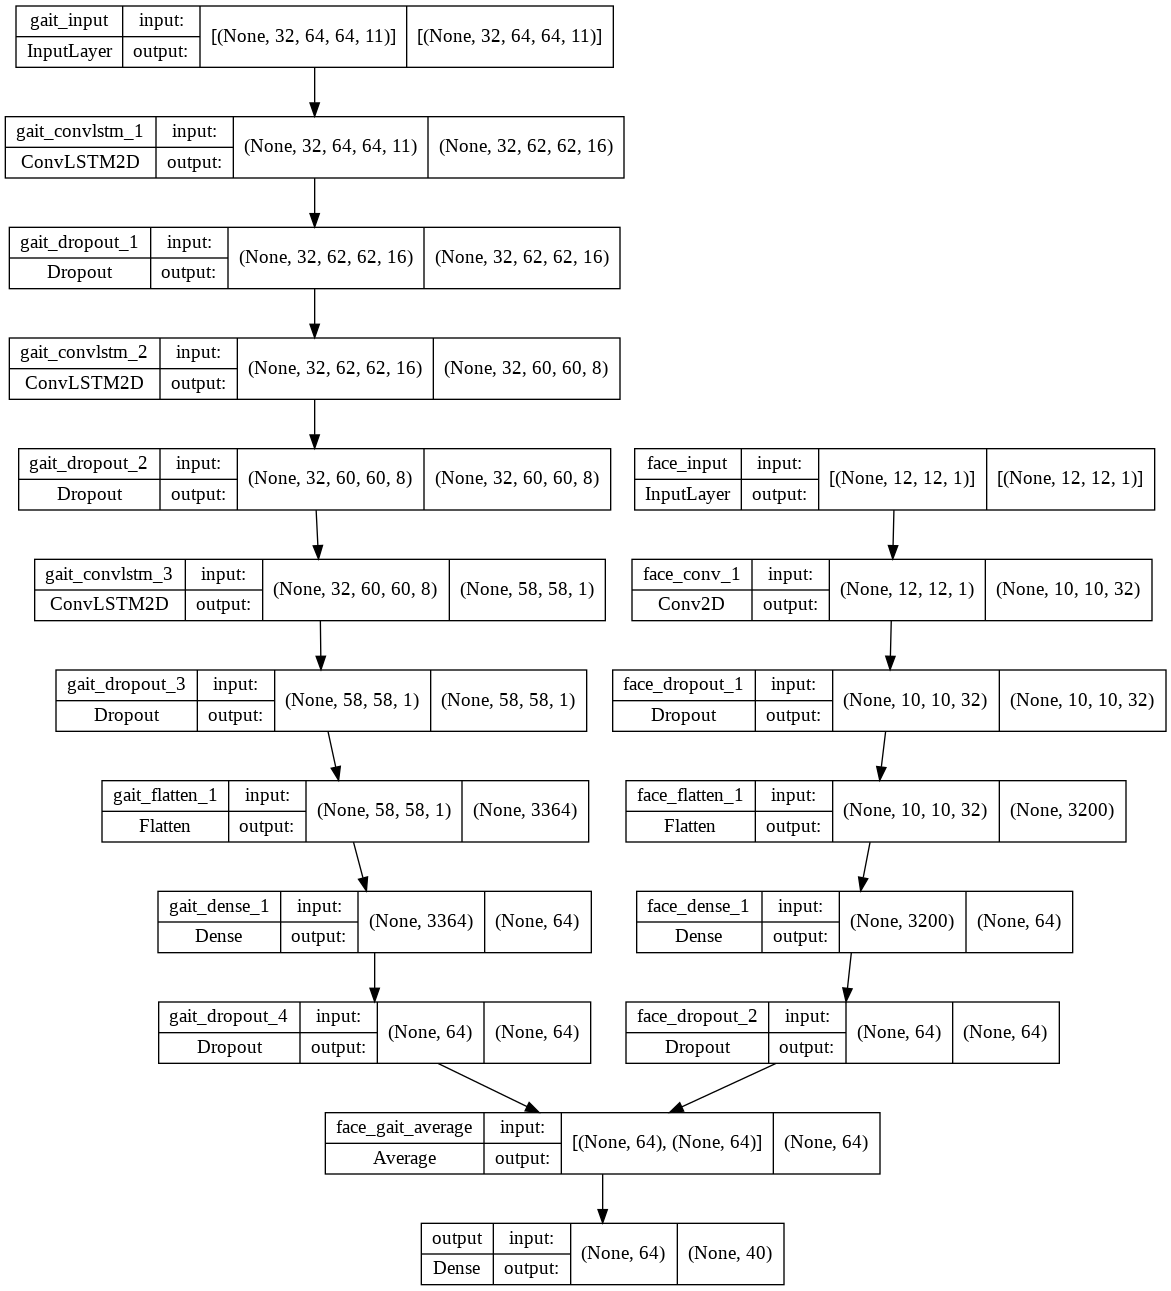

In [7]:
plot = plot_model(model, show_shapes = True, to_file = 'model.png', show_layer_names = True)
display(plot)

In [8]:
EPOCHS = 20
BATCH_SIZE = 4
VALID_SPLIT = 0.25

history = model.fit([x_face, x_gait], y, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split = VALID_SPLIT)

Epoch 1/20
75/75 [==============================] - 61s 617ms/step - loss: 6.4709 - accuracy: 0.0300 - val_loss: 3.6812 - val_accuracy: 0.0800
Epoch 2/20
75/75 [==============================] - 44s 592ms/step - loss: 3.5805 - accuracy: 0.0867 - val_loss: 3.5444 - val_accuracy: 0.0700
Epoch 3/20
75/75 [==============================] - 44s 590ms/step - loss: 3.2791 - accuracy: 0.1500 - val_loss: 3.2130 - val_accuracy: 0.1600
Epoch 4/20
75/75 [==============================] - 45s 605ms/step - loss: 2.6961 - accuracy: 0.2533 - val_loss: 2.5789 - val_accuracy: 0.2500
Epoch 5/20
75/75 [==============================] - 45s 606ms/step - loss: 1.9863 - accuracy: 0.4100 - val_loss: 2.2088 - val_accuracy: 0.3600
Epoch 6/20
75/75 [==============================] - 46s 608ms/step - loss: 1.5373 - accuracy: 0.5167 - val_loss: 1.7340 - val_accuracy: 0.4800
Epoch 7/20
75/75 [==============================] - 45s 606ms/step - loss: 1.2502 - accuracy: 0.5967 - val_loss: 1.5822 - val_accuracy: 0.5100

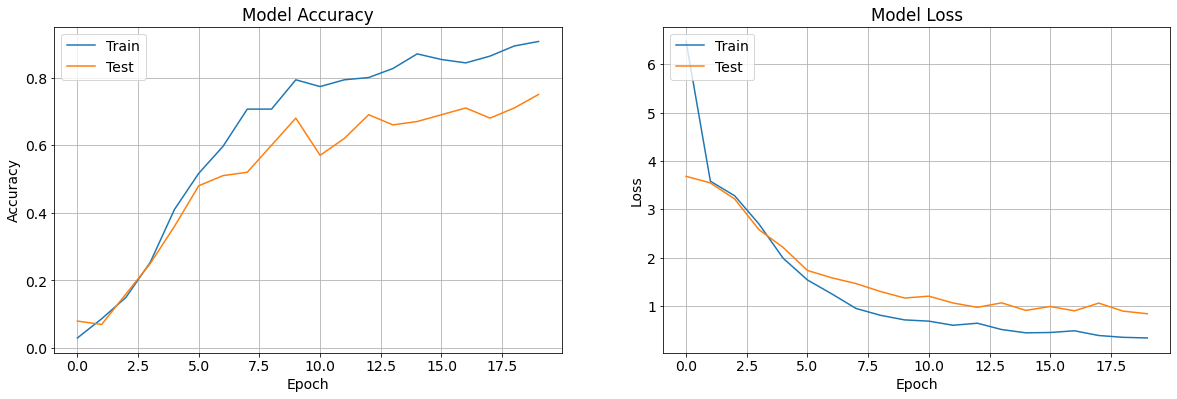

In [9]:
plt.rcParams['figure.figsize'] = (20, 6)
plt.rcParams['font.size'] = 14

fig, ax = plt.subplots(1, 2)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Test'], loc='upper left')
ax[0].grid()

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Test'], loc='upper left')
ax[1].grid()

plt.show()